In [4]:
# load model
import os
from transformers import DebertaForSequenceClassification, DebertaTokenizer
from transformers import Trainer, TrainingArguments
from data_analysis_and_preprocessing import data_preprocessing
from data.dont_patronize_me import DontPatronizeMe
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import f1_score
import torch
from matplotlib import pyplot as plt

In [2]:
cd '/content/drive/MyDrive/NLP/nlp-coursework-1-master'

/content/drive/MyDrive/NLP/nlp-coursework-1-master


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q accelerate==0.27.2
!pip install -q simpletransformers
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 56

In [5]:
def preprocess_data(data):
    data = data_preprocessing.remove_h_tags(data)
    data = data_preprocessing.remove_ampersands(data)
    data = data_preprocessing.remove_mentions(data)
    data = data_preprocessing.remove_contractions(data)
    data = data_preprocessing.remove_extra_spaces(data)
    return data


def get_rows(data):
    rows = [] # will contain par_id, label and text
    for idx in data.index:
        parid = data.loc[idx]['par_id']
        instance = data.loc[idx]
        keyword = instance['keyword']
        text = instance['text']
        text = keyword + ' | ' + text

        rows.append({
            'par_id':parid,
            'text':text,
            'label':instance['label']
        })
    return rows


def load_data():
    dpm = DontPatronizeMe('.', '.')
    dpm.load_task1()
    teids = pd.read_csv('data/dev_semeval_parids-labels.csv')
    teids.par_id = teids.par_id.astype(str)
    data = dpm.train_task1_df

    rows_test = [] # will contain par_id, label and text
    for idx in range(len(teids)):
        parid = teids.par_id[idx]
        #print(parid)
        # select row from original dataset
        instance = data.loc[data.par_id == parid]
        keyword = instance.keyword.values[0]
        text = instance.text.values[0]
        label = instance.label.values[0]
        country = instance.country.values[0]
        rows_test.append({
            'par_id':parid,
            'keyword':keyword,
            'country':country,
            'text':text,
            'label':label
        })

    test_set = pd.DataFrame(rows_test)
    test_set = preprocess_data(test_set)

    rows_test = get_rows(test_set)
    test_dataframe = pd.DataFrame(rows_test)

    return test_dataframe
test_set = load_data()

# Load the DeBERTa tokenizer
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
test_text = test_set.text.values

max_length = 192

encoding_test = tokenizer(test_text.tolist(), return_tensors='pt', padding="max_length", truncation=True, max_length=max_length)
encoding_test['label'] = torch.tensor([[0,1] if x == 1 else [1,0] for x in test_set['label'].tolist()], dtype=torch.float32)
encoding_test

/content/drive/MyDrive/NLP/nlp-coursework-1-master/data_analysis_and_preprocessing/data_preprocessing.py:47: FutureWarning: Possible nested set at position 3
  data_no_mentions.at[index, 'text'] = re.sub(r'@([[a-z]|[A-Z]|[1-9]|0])+\s', '', data_no_mentions['text'][index][:5])
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

{'input_ids': tensor([[    1,  9547, 13802,  ...,     0,     0,     0],
        [    1, 13043, 11797,  ...,     0,     0,     0],
        [    1, 13043, 11797,  ...,     0,     0,     0],
        ...,
        [    1, 46241,  1721,  ...,     0,     0,     0],
        [    1, 22197,  1721,  ...,     0,     0,     0],
        [    1,   705, 39010,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'label': tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])}

In [6]:
class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        train_input_ids = self.encodings.input_ids[idx]
        train_token_type_ids = self.encodings.token_type_ids[idx]
        train_attention_mask = self.encodings.attention_mask[idx]
        train_labels = self.encodings.label[idx]
        return {
            'input_ids': train_input_ids,
            'token_type_ids': train_token_type_ids,
            'attention_mask': train_attention_mask,
            'labels': train_labels
        }

    def __len__(self):
        return len(self.encodings.input_ids)
test_dataset = CustomDataset(encoding_test)

In [7]:
trainingargs = TrainingArguments(output_dir='training_results/bachillerato')

# load model
model = DebertaForSequenceClassification.from_pretrained('final_model')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    labels = np.argmax(labels, axis=-1)
    f1 = f1_score(labels, predictions, average='binary')
    return {'f1': f1}
trainer = Trainer(
    model=model,
    args=trainingargs,
    train_dataset=None,
    eval_dataset=None,
    compute_metrics=compute_metrics
)

In [8]:
prediction_output = trainer.predict(test_dataset)

# Check if the dataset is correctly loaded

In [9]:
teids = pd.read_csv('data/dev_semeval_parids-labels.csv')
teids.par_id = teids.par_id.astype(str)
labels = prediction_output.label_ids
predicted_labels = np.argmax(prediction_output.predictions, axis=1)
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()
data = dpm.train_task1_df


correct_length_bin = []
wrong_length_bin = []

strength_bins = {strength: 0 for strength in data.orig_label.unique()}
strength_overall = {strength: 0 for strength in data.orig_label.unique()}
country_bins = {country: 0 for country in data.country.unique()}
keyword_bins = {keyword: 0 for keyword in data.keyword.unique()}
keyword_overall = {keyword: 0 for keyword in data.keyword.unique()}


# iterate through teids' rows
for idx in range(len(teids)):
    country = data.loc[data.par_id == teids.par_id[idx]].country.values[0]
    keyword = data.loc[data.par_id == teids.par_id[idx]].keyword.values[0]
    strength = data.loc[data.par_id == teids.par_id[idx]].orig_label.values[0]
    text_len = len(data.loc[data.par_id == teids.par_id[idx]].text.values[0].split())
    if teids.label[idx]=="[0, 0, 0, 0, 0, 0, 0]":
        true_label = 0
    else:
        true_label = 1
    predicted_label = predicted_labels[idx]
    strength_overall[strength] += 1
    keyword_overall[keyword] += 1
    if true_label == predicted_label:
        correct_length_bin.append(text_len)
    else:
        wrong_length_bin.append(text_len)
        strength_bins[strength] += 1
        country_bins[country] += 1
        keyword_bins[keyword] += 1



In [10]:
strength_bins = {strength: strength_bins[strength] / strength_overall[strength] for strength in strength_bins}
keyword_bins = {keyword: keyword_bins[keyword] / keyword_overall[keyword] for keyword in keyword_bins}

In [11]:
keyword_bins = {k: v for k, v in sorted(keyword_bins.items(), key=lambda item: item[1])}

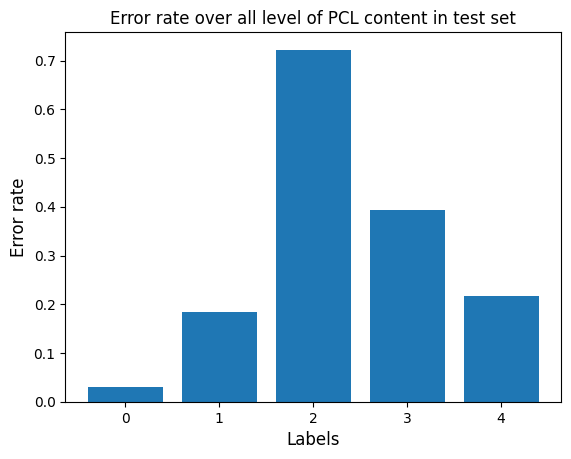

In [12]:
fig, ax = plt.subplots()
ax.set_title("Error rate over all level of PCL content in test set")
ax.bar(strength_bins.keys(), strength_bins.values())
#ax.set_xticklabels(strength_bins.keys())
ax.set_xlabel("Labels", fontsize = 12)
ax.set_ylabel("Error rate", fontsize = 12)
plt.savefig('/content/drive/MyDrive/NLP/PCL_level.png',dpi = 300)

<ipython-input-13-866cf97b4245>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keyword_bins.keys(), rotation=25,ha="right")


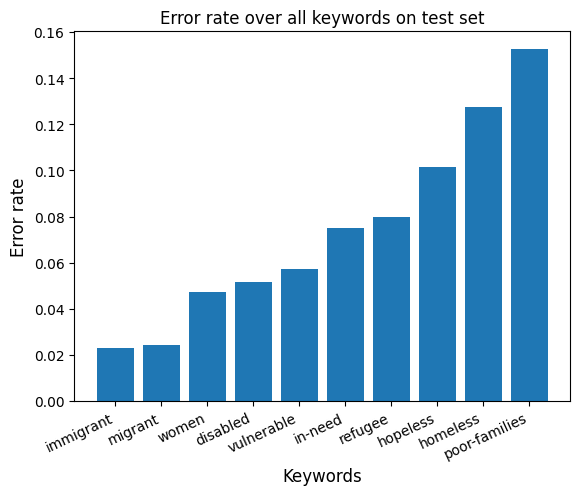

In [13]:
fig, ax = plt.subplots()
ax.set_title("Error rate over all keywords on test set")
ax.bar(keyword_bins.keys(), keyword_bins.values())
ax.set_xticklabels(keyword_bins.keys(), rotation=25,ha="right")
ax.set_xlabel("Keywords", fontsize = 12)
ax.set_ylabel("Error rate", fontsize = 12)
plt.savefig('/content/drive/MyDrive/NLP/keywords.png',dpi = 300)

In [14]:
keyword_bins

{'immigrant': 0.022935779816513763,
 'migrant': 0.024154589371980676,
 'women': 0.04721030042918455,
 'disabled': 0.05154639175257732,
 'vulnerable': 0.05741626794258373,
 'in-need': 0.0752212389380531,
 'refugee': 0.0797872340425532,
 'hopeless': 0.10138248847926268,
 'homeless': 0.12735849056603774,
 'poor-families': 0.15263157894736842}

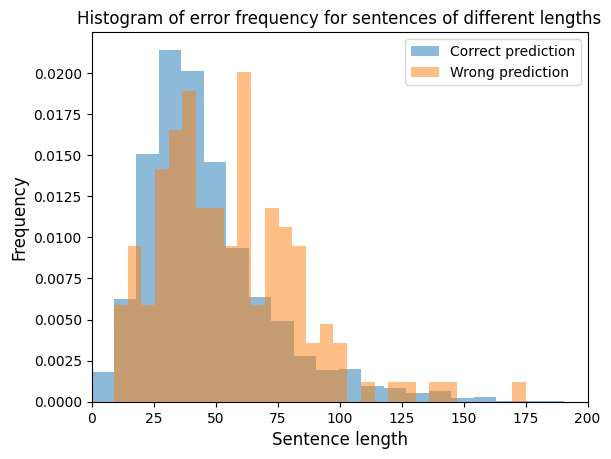

In [15]:

fig, ax = plt.subplots()

ax.hist(correct_length_bin, bins=30, alpha=0.5, label='Correct prediction', density=True)
ax.hist(wrong_length_bin, bins=30, alpha=0.5, label='Wrong prediction', density=True)
ax.set_xlim([0,200])
ax.set_title('Histogram of error frequency for sentences of different lengths')
ax.set_ylabel('Frequency', fontsize = 12)
ax.set_xlabel('Sentence length', fontsize = 12)
ax.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/NLP/length.png',dpi = 300)

In [ ]:
prediction_output